One of the big breakthroughs with deep learning has been increased accuracy in identifying people across a large collection of photos. Facebook pioneered an approach called [DeepFace](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/) in 2014 that achieved 97% accuracy on a dataset called [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (or LFW), containing 13,000 photos of 1680 unique people.

To get to that level of accuracy, there are a few independent steps. First we have to find the faces in the image (face detection), then identify the exact center and orientation of the face (landmark detection), and then we convert the image to a high dimensional representation that captures a "description" of the face. Each of these steps on their own is a bit difficult, but the library [dlib](http://dlib.net/) implements all of these steps and achieves 99% accuracy on LFW.

First we import some libraries and tools we will be using:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dlib
from skimage import io
from show_array import show_array
from draw_shapes import draw_circle, draw_rectangle

Then we load this photo featuring a bunch of white guys.

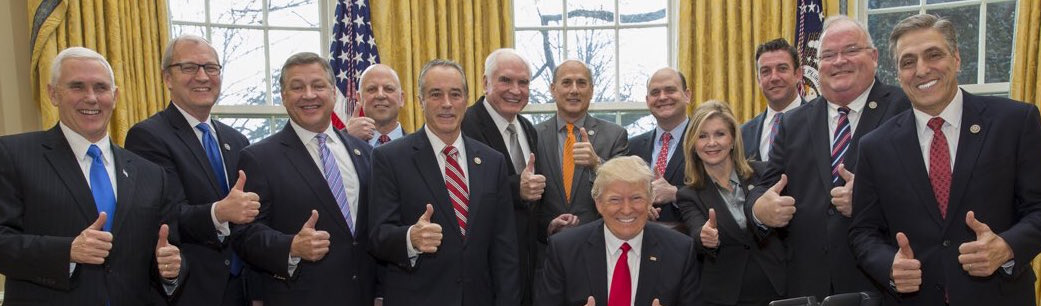

In [2]:
img = io.imread('whiteguys.jpg')
show_array(img)

We want to detect every single homogenous face in this photo, so we need to load a face detector. The face detector is built in to dlib so we don't need to load it from a file.

In [3]:
detector = dlib.get_frontal_face_detector()

Once the detector is loaded, we run the detector on the image and draw rectangles around each of their empty heads.

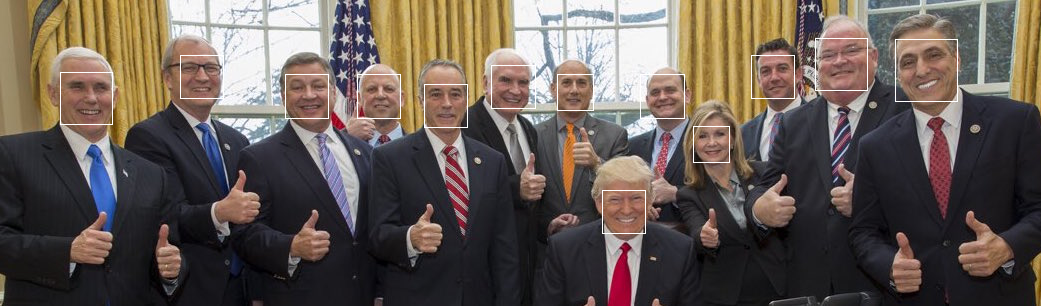

In [4]:
boxes = detector(img, 1) # 1 means upsample the image once, which helps with detecting the smaller faces
canvas = img.copy() # make a copy of the image to draw into
for box in boxes:
    draw_rectangle(canvas, box, stroke=(255, 255, 255))
show_array(canvas)

Next we want to get an accurate idea of exactly where their faces are located in a way that's more precise than the initial detector bounding box. The shape predictor also tells us how much their faces are rotated (most apparent on the right side, head nodding is a symbol of deference often associated with cowardice).

In [5]:
shape_predictor = dlib.shape_predictor('../../models/dlib/landmarks.dat')

With the shape predictor loaded, we run run it once on each of the detected bounding boxes and collect the results.

In [6]:
shapes = [shape_predictor(img, box)
          for box in boxes]

Now we draw every landmark in every shape as a small white circle.

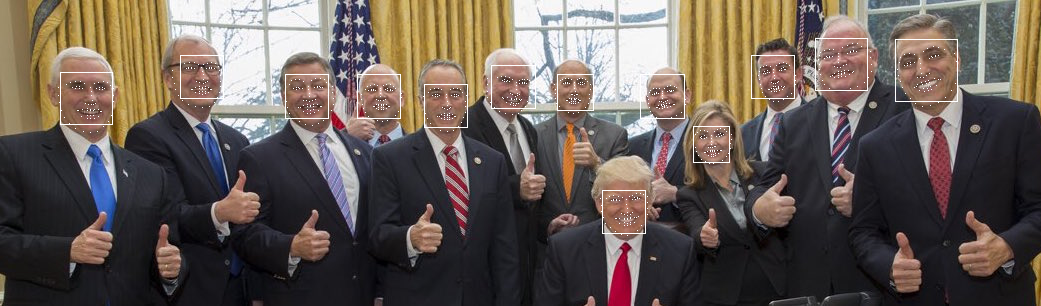

In [7]:
for shape in shapes:
    for part in shape.parts():
        draw_circle(canvas, (part.y, part.x), fill=(255,255,255))
show_array(canvas)

With all these landmarks, we have what we need to do comparisons between faces in terms of similarity. But first we need to load a face recognizer. The face recognizer is trained on a huge database of faces, and optimized to create a similar "encoding" or "description" for photos of the same person, and a different "description" for different people.

In [8]:
face_recognizer = dlib.face_recognition_model_v1('../../models/dlib/recognition.dat')

Like above with the shape predictor with all the bounding boxes, here we run the face recognizer on all the shapes.

In [9]:
descriptors = [face_recognizer.compute_face_descriptor(img, shape)
               for shape in shapes]
descriptors = np.array(descriptors) # convert from dlib vectors to numpy array
print(descriptors.shape)

(13, 128)


Each of these descriptions is a 128-dimensional vector, but to put them to work let's look at some comparisons between the faces in the image. In this case we have 13 faces, so there are $(13*(13-1))/2=78$ comparisons we could make. For each comparison we use `np.linalg.norm` which is just standard Euclidean distance.

In [10]:
comparisons = []
number_faces = len(descriptors)
for i in range(number_faces):
    for j in range(i+1, number_faces):
        distance = np.linalg.norm(descriptors[i] - descriptors[j])
        comparisons.append((distance, i, j))
print(len(comparisons))

78


Smaller distances mean the comparison is between two similar-looking people. So if we sort the comparisons we can pull out the top few pairs.

Matches 9 and 11 are similar (0.558807371761).


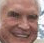

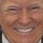

Matches 6 and 8 are similar (0.568076389631).


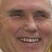

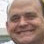

Matches 0 and 6 are similar (0.591489088244).


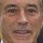

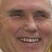

In [11]:
def image_region(img, det):
    top = max(det.top(), 0)
    bottom = min(det.bottom(), img.shape[0]-1)
    left = max(det.left(), 0)
    right = min(det.right(), img.shape[1]-1)
    return img[top:bottom, left:right]
    
comparisons.sort()

for distance, i, j in comparisons[:3]:
    print('Matches {} and {} are similar ({}).'.format(i, j, distance))
    show_array(image_region(img, boxes[i]))
    show_array(image_region(img, boxes[j]))

Fair enough, I guess Pence does look a little like everyone. And that guy could be a relative of Trump, I wouldn't really be surprised. But who looks the most *different* in this photo? Let's take the last few matches.

Matches 1 and 12 are dissimilar (0.916751168259).


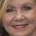

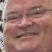

Matches 0 and 1 are dissimilar (0.971662320987).


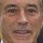

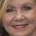

Matches 1 and 2 are dissimilar (0.97507369328).


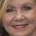

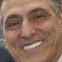

In [12]:
for distance, i, j in comparisons[-3:]:
    print('Matches {} and {} are dissimilar ({}).'.format(i, j, distance))
    show_array(image_region(img, boxes[i]))
    show_array(image_region(img, boxes[j]))

Well would you look at that, there's one lady in this photo. I completely missed her. In that case, she really is the person who looks the most different.

Let's add up the distance/similarity values for each person, and we can figure out who looks the most like everyone else in the photo, and who looks the least like everyone else. First we loop through our comparisons and track the distances on a per-person basis.

In [13]:
sum_distance = np.zeros(number_faces)
for distance, i, j in comparisons:
    sum_distance[i] += distance
    sum_distance[j] += distance

And then we look at the smallest total distance and draw that region:

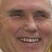

In [14]:
sum_distance_min = np.argmin(sum_distance)
show_array(image_region(img, boxes[sum_distance_min]))

As suspected, Pence looks the most similar. And the most dissimilar? Who looks like they don't belong?

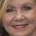

In [15]:
sum_distance_max = np.argmax(sum_distance)
show_array(image_region(img, boxes[sum_distance_max]))

It's her again! Just to be super clear, let's highlight both of them.

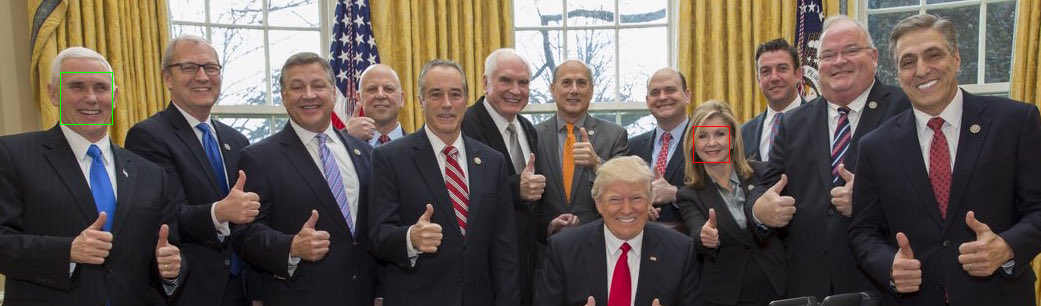

In [16]:
canvas = img.copy()
draw_rectangle(canvas, boxes[sum_distance_min], stroke=(0,255,0)) # green
draw_rectangle(canvas, boxes[sum_distance_max], stroke=(255,0,0)) # red
show_array(canvas)